In [1]:
!nvidia-smi

Wed Jul 13 00:35:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/hoanshiro/Smartphone-ABSA

fatal: destination path 'Smartphone-ABSA' already exists and is not an empty directory.


In [3]:
import os
base_path = '/home/henry/Desktop/'
os.chdir(base_path + "Smartphone-ABSA/")

## 1. Load data

### 1.1 Import libaries

In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tqdm
from collections import defaultdict

import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

### 1.2 Load Data

In [4]:
df_train = pd.read_csv('data/processed_data/processed_train.csv')
df_valid = pd.read_csv('data/processed_data/processed_valid.csv')
df_test = pd.read_csv('data/processed_data/processed_test.csv')

In [5]:
df_train.tail(5)

,tokenize,SCREEN#Positive,SCREEN#Neutral,SCREEN#Negative,CAMERA#Positive,CAMERA#Neutral,CAMERA#Negative,FEATURES#Positive,FEATURES#Neutral,FEATURES#Negative,...,DESIGN#Negative,PRICE#Positive,PRICE#Neutral,PRICE#Negative,GENERAL#Positive,GENERAL#Neutral,GENERAL#Negative,SER&ACC#Positive,SER&ACC#Neutral,SER&ACC#Negative
7781,8g cái đi đánh là mạng giật giật ko chịu nổi c...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7782,mua dk giảm 500k mà lỗi lòi ra hết treo màn_hì...,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
7783,máy sài 3 tháng rồi rất ok pin trâu khỏi nói s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7784,rất tiếc hàng realme ko có ốp lưng ngoài nên k...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
7785,mình rất thất_vọng khi mua máy này bắt wifi cự...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


## 2. Prepare Dataset

### 2.1 Select Max Length

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7786/7786 [00:01<00:00, 5355.40it/s]
/home/henry/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


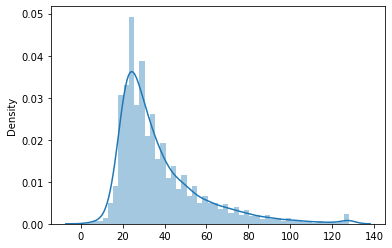

In [8]:
from src.utils import DisplayTokenLen
DisplayTokenLen(df_train, tokenizer)

### 2.2 Check Data

In [9]:
# Test the tokenizer
test_text = "máy sài 3 tháng rồi rất ok pin trâu khỏi nói sài cả ngày đến tối 12 giờ đêm mới sạc mình chơi game liên_quân cả ngày rất ok"
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 128,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[    0,   558,  1302,  9412,   107,    78,   182,    59, 11685,  2179,
          2959,   353,    96,  1302,  9412,    94,    43,    30,   878,   445,
           232,   396,    60,  3941,    68,   379,  1724,  7660,    94,    43,
            59, 11685,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

### 2.3 Transform dataset for Pytorch Model

In [22]:
from src.utils import GetNewLabels
from src.conf import AbsaConfig
from src.model import CustomDataset
conf = AbsaConfig()
target_list = GetNewLabels()
MAX_LEN = conf.MAX_LEN
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [13]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([    0,    60,   188,   558,    23,    35, 44553,  3385,  3385,  2662,
         33640,   841, 11685,  5967,  2959,   690,   284,   258,  3998,   523,
           889,   537,  2303,  3961,  3455,  1575,   726,  4097,   164,    15,
         11535,   650,  1408,  3857,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [14]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=conf.TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=conf.VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=conf.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

## 3. Model Setting

In [15]:
from src.model import BERTClass

model = BERTClass()
# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False
model.to(conf.device)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [16]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

/home/henry/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4. Training

In [17]:
from src.utils import SupportModel

In [18]:
ModelSupporter = SupportModel()

In [24]:
# history = defaultdict(list)
# best_accuracy = 0
# EPOCHS = conf.EPOCHS
# data_dir = conf.data_dir
# for epoch in range(1, EPOCHS+1):
#     print(f'Epoch {epoch}/{EPOCHS}')
#     model, train_acc, train_loss = ModelSupporter.train_model(train_data_loader, model, optimizer)
#     val_acc, val_loss = ModelSupporter.eval_model(val_data_loader, model, optimizer)

#     print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

#     history['train_acc'].append(train_acc)
#     history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_acc)
#     history['val_loss'].append(val_loss)
#     # save the best model
#     if val_acc > best_accuracy:
#         torch.save(model.state_dict(), os.path.join(data_dir,"output","MLTC_model_state.bin"))
#         best_accuracy = val_acc

In [25]:
# PlotTrainingHistory(history)

## 5. Evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
# # Loading pretrained model (best model)
# model = BERTClass()
# model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))
# model = model.to(device)

In [27]:
# Evaluate the model using the test data
# test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [28]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
# test_acc

In [29]:
# comments, predictions, prediction_probs, target_values = ModelSupporter.get_predictions(model, test_data_loader)

In [30]:
# print(f"comments:{len(comments)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

In [31]:
# # Generate Classification Metrics
# # note that the total support is greater than the number of samples
# # some samples have multiple lables

# print(classification_report(target_values, predictions, target_names=target_list))

## 6. Predict Raw Input

In [32]:
# ModelSupporter.predict_raw_text(model, tokenizer, raw_text='')

## 7.BigDL

### 7.1  Environment Preparation

Java

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

Python 3.8

In [ ]:
import sys
# Set current python version
python_version = f"3.8"
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# Update Conda
!conda install --channel defaults conda python=$python_version --yes
!conda update --channel defaults --all --yes

# Append to the sys.path
_ = (sys.path
        .append(f"/usr/local/lib/python3.7/site-packages"))

os.environ['PYTHONHOME']="/usr/local"

### 7.2 BigDL dependency

In [ ]:
!pip install bigdl-orca
!pip install six cloudpickle

In [ ]:
!python3 -m pip install jep==3.9.0

### 7.3 Init Orca Context

In [25]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [ ]:
from bigdl.orca import init_orca_context, stop_orca_context

cluster_mode = "local"
if cluster_mode == "local":  # For local machine
    init_orca_context(cores=2, memory="4g")
elif cluster_mode == "k8s":  # For K8s cluster
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=2, memory="10g", driver_memory="10g", driver_cores=1)
elif cluster_mode == "yarn":  # For Hadoop/YARN cluster
    init_orca_context(
    cluster_mode="yarn", cores=2, num_nodes=2, memory="10g",
    driver_memory="10g", driver_cores=1,
    conf={"spark.rpc.message.maxSize": "1024",
        "spark.task.maxFailures": "1",
        "spark.driver.extraJavaOptions": "-Dbigdl.failure.retryTimes=1"})

### 7.4 Training

#### 7.4.1 Convert Pytorch Model to BigDL Model

In [ ]:
from bigdl.orca.learn.pytorch import Estimator 
from bigdl.orca.learn.metrics import Accuracy
from bigdl.orca.learn.pytorch.pytorch_spark_estimator import PyTorchSparkEstimator
model.train()
criterion = torch.nn.BCEWithLogitsLoss()
est = PyTorchSparkEstimator(model=model,
                           optimizer=optimizer,
                           loss=criterion)

#### 7.4.2 Fit

In [ ]:
from bigdl.orca.learn.trigger import EveryEpoch 

est.fit(data=train_data_loader, epochs=10, validation_data=val_data_loader,
        checkpoint_trigger=EveryEpoch())

#### 7.4.3 Evaluate

In [ ]:
result = est.evaluate(data=test_data_loader, batch_size=conf.TEST_BATCH_SIZE)
for r in result:
    print(r, ":", result[r])

#### 7.4.5 Stop orca context

In [ ]:
# stop orca context when program finishes
stop_orca_context()